In [1]:
# 载入必要的库
import numpy as np
import tensorflow as tf
import keras

from matplotlib import pyplot as plt

from keras import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D
from keras.layers import Flatten, Dropout, Dense, Input, concatenate
from tensorflow.keras.applications import VGG16

Using TensorFlow backend.


## 读取数据 

###  构建数据生成器

In [6]:
IMSIZE=224

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    './data_inception/train/',
    target_size=(IMSIZE, IMSIZE),
    batch_size=100,
    class_mode='categorical')

validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    './data_inception/test/',
    target_size=(IMSIZE, IMSIZE),
    batch_size=100,
    class_mode='categorical')

Found 952 images belonging to 17 classes.
Found 408 images belonging to 17 classes.


###  可视化

<Figure size 432x288 with 0 Axes>

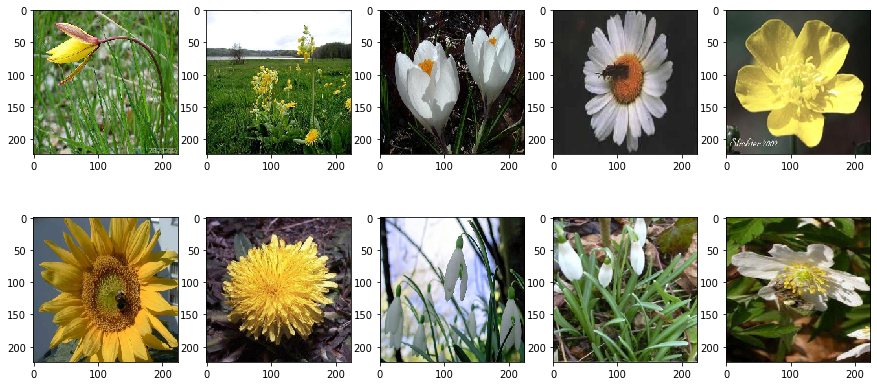

In [7]:
plt.figure()
fig,ax = plt.subplots(2,5)
fig.set_figheight(7)
fig.set_figwidth(15)
ax=ax.flatten()
X,Y=next(train_generator)
for i in range(10): ax[i].imshow(X[i,:,:,:])

## 构建Inception模型 

### 模型建立 

In [8]:
#输入：224*224*3
input_layer = Input([IMSIZE,IMSIZE,3]) 
x = input_layer

#第一层:使用7x7的卷积核（滑动IMSIZE = 224,步长2，same padding），64通道；然后经过3x3的max pooling（步长为2）
x = Conv2D(64,(7,7),strides=(2,2),padding='same',activation='relu')(x) #para=(3*7*7+1)*64=9472
x = BatchNormalization(axis=3)(x) #para=4*64=256
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x) 

#第二层:使用3x3的卷积核（滑动步长为1，same padding），192通道；然后经过3x3的max pooling（步长为2）
x = Conv2D(192,(3,3),strides=(1,1),padding='same',activation='relu')(x) #para=(64*3*3+1)*192=110784
x = BatchNormalization(axis=3)(x) #para=4*192=768
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x) 

for i in range(9):
    #第三层:Inception 3a。后面的3b，4a-4e，5a，5b都用3a近似替代
    ##64个1x1的卷积核
    branch1x1 = Conv2D(64,(1,1),strides=(1,1),padding='same',activation='relu')(x) #para=(192*1*1+1)*64=12352
    branch1x1 = BatchNormalization(axis=3)(branch1x1) #para=4*64=256
    ##96个1x1的卷积核，再进行128个3x3的卷积
    branch3x3 = Conv2D(96,(1,1),strides=(1,1),padding='same',activation='relu')(x) #para=(192*1*1+1)*96=18528
    branch3x3 = BatchNormalization(axis=3)(branch3x3) #para=4*96=384
    branch3x3 = Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu')(branch3x3) #para=(96*3*3+1)*128=110720
    branch3x3 = BatchNormalization(axis=3)(branch3x3) #para=4*128=512
    ##16个1x1的卷积核，再进行32个5x5的卷积
    branch5x5 = Conv2D(16,(1,1),strides=(1,1),padding='same',activation='relu')(x) #para=(192*1*1+1)*16=3088
    branch5x5 = BatchNormalization(axis=3)(branch5x5) #para=4*16=64
    branch5x5 = Conv2D(32,(5,5),strides=(1,1),padding='same',activation='relu')(branch5x5) #para=(16*5*5+1)*32=12832
    branch5x5 = BatchNormalization(axis=3)(branch5x5) #para=4*32=128
    ##pool层，使用3x3的核，输出28x28x192，然后进行32个1x1的卷积
    branchpool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x)
    branchpool = Conv2D(32,(1,1),strides=(1,1),padding='same',activation='relu')(branchpool) #para=(192*1*1+1)*32=6176
    branchpool = BatchNormalization(axis=3)(branchpool) #para=4*32=128
    x = concatenate([branch1x1,branch3x3,branch5x5,branchpool],axis=3)
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)


x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(17,activation='softmax')(x)
output_layer=x
model=Model(input_layer,output_layer)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_57 (BatchNo (None, 112, 112, 64) 256         conv2d_57[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 56, 56, 64)   0           batch_normalization_57[0][0]     
____________________________________________________________________________________________

### 模型编译及拟合 

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
model.fit(train_generator,epochs=5,validation_data=validation_generator)